# Deep Autoencoder on MNIST Dataset

<img src="https://4.bp.blogspot.com/-oUcusrWxk2U/WkntSbY7EQI/AAAAAAAAXHM/SzJ7vLUDu4U0IV5QfxQj-6W78h6-JUfSwCLcBGAs/s1600/4110_2.PNG" width="500" height="300">

Autoencoder is useful in extracting latent representation of high dimensional data, and with latent space visualization, we can see how the original data is distributed with new learned features. Most importantly for my case, not with this dataset though, but with the images I'm currently working on at my company, this technique could be used to detect anomalies if together we implement clustering or other outlier techniques such as isolation forest or local outlier factor.

In [1]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import numpy as np

from keras.datasets import mnist
from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras.callbacks import EarlyStopping
from keras import backend as K
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# config.gpu_options.per_process_gpu_memory_fraction = 0.48
set_session(tf.Session(config=config))
K.get_session().run(tf.global_variables_initializer())

import sys
sys.path.append('util/')
from util import plotProgress

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.reshape(60000,-1)
X_test = X_test.reshape(10000,-1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

60000 train samples
10000 test samples


In [4]:
epochs = 50
batch = 64
latent_dim = 2
inter_dim1 = 128
inter_dim2 = 64
inter_dim3 = 32
inter_dim4 = 10
optimizer = 'adam'

In [5]:
inputs=Input(shape = (X_train.shape[1],))
x = inputs
x = Dense(inter_dim1,activation='relu')(x)
x = Dense(inter_dim2,activation='relu')(x)
x = Dense(inter_dim3,activation='relu')(x)
x = Dense(inter_dim4,activation='relu')(x)
latent = Dense(latent_dim)(x)
encoder = Model(inputs,latent,name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 22        
Total params: 111,168
Trainable params: 111,168
Non-trainable params: 0
_________________________________________________________________


In [6]:
decode_in = Input(shape = (latent_dim,))
decode = Dense(inter_dim4,activation = 'relu')(decode_in)
decode = Dense(inter_dim3,activation = 'relu')(decode)
decode = Dense(inter_dim2,activation = 'relu')(decode)
decode = Dense(inter_dim1,activation = 'relu')(decode)
decode = Dense(X_train.shape[1],activation = 'sigmoid')(decode)
decoder = Model(decode_in,decode)
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_7 (Dense)              (None, 32)                352       
_________________________________________________________________
dense_8 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_9 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_10 (Dense)             (None, 784)               101136    
Total params: 111,950
Trainable params: 111,950
Non-trainable params: 0
_________________________________________________________________


In [7]:
autoencoder = Model(inputs,decoder(encoder(inputs)))
autoencoder.compile(optimizer = optimizer,loss = 'mse')

In [8]:
history = autoencoder.fit(X_train,X_train,
                        epochs = epochs,
                        batch_size = batch,
                        validation_data = (X_test,X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 91us/step - loss: 0.0668 - val_loss: 0.0534
Epoch 2/50
60000/60000 [==============================] - 5s 80us/step - loss: 0.0489 - val_loss: 0.0457
Epoch 3/50
60000/60000 [==============================] - 5s 79us/step - loss: 0.0441 - val_loss: 0.0429
Epoch 4/50
60000/60000 [==============================] - 5s 81us/step - loss: 0.0423 - val_loss: 0.0418
Epoch 5/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.0413 - val_loss: 0.0407
Epoch 6/50
60000/60000 [==============================] - 5s 82us/step - loss: 0.0405 - val_loss: 0.0402
Epoch 7/50
60000/60000 [==============================] - 5s 81us/step - loss: 0.0403 - val_loss: 0.0400
Epoch 8/50
60000/60000 [==============================] - 5s 82us/step - loss: 0.0396 - val_loss: 0.0393
Epoch 9/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.0391 - val_loss: 0.0391
Epoch

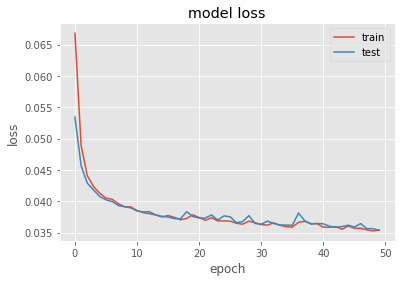

In [9]:
plotProgress(history)

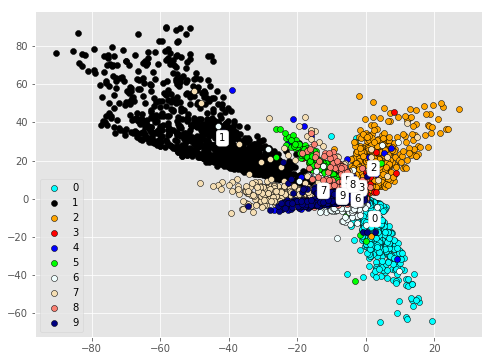

In [10]:
# get latent variables
lat = encoder.predict(X_test)
# plot scatter
cmap = ['cyan','black','orange','red','blue','lime','azure','wheat','salmon','navy']
fig,ax=plt.subplots(figsize = (8,6))
for i in range(10):
    ax.scatter(lat[y_test == i,0],lat[y_test == i,1],
                edgecolors = 'black',
                c = cmap[i],
                label = str(i))
    ax.annotate(str(i),(lat[y_test == i,0].mean(),lat[y_test == i,1].mean()),
               bbox = dict(boxstyle = "round", fc = "w"))
plt.legend()

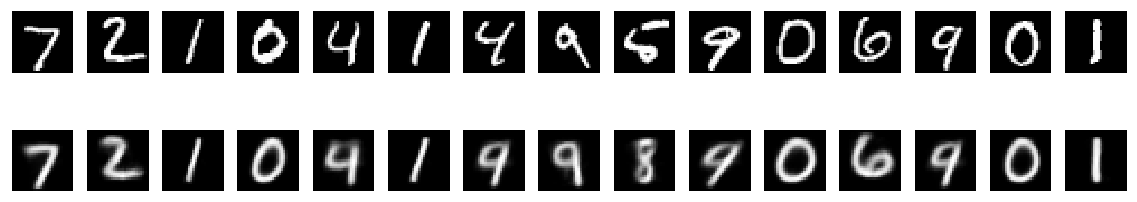

In [11]:
# get decoded digits
reconstructed = decoder.predict(lat)
# plot decoded
n = 15
plt.figure(figsize = (20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # reconstructed
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()